# TD : Random Forests pour la Finance
## Master 2 Banque Finance Assurance - Paris Dauphine
## VERSION ENSEIGNANT (avec solutions)

**Durée totale :** 3 heures  
**Prérequis :** TD Arbres de Décision

**Objectifs pédagogiques :**
- Comprendre les méthodes d'ensemble (Bagging)
- Maîtriser les Random Forests et leurs hyperparamètres
- Comparer RF vs Decision Trees simples
- Interpréter et visualiser les modèles RF
- Appliquer à un cas réel de scoring crédit

---

## Partie 1 : Théorie (30 minutes)

### 1.1 Introduction : La Sagesse des Foules (Wisdom of Crowds)

**Expérience célèbre de Francis Galton (1906)** :
- 800 personnes estiment le poids d'un bœuf dans une foire agricole
- Poids réel : 1198 livres
- **Moyenne des estimations** : 1197 livres (erreur de 0.08% !)
- Aucune estimation individuelle n'était aussi précise

**Principe :** L'agrégation de multiples estimations imparfaites peut produire une prédiction excellente.

**En Machine Learning :**
- Au lieu d'un seul modèle (arbre de décision)
- On entraîne **plusieurs modèles** (forêt d'arbres)
- On **agrège** leurs prédictions (vote majoritaire ou moyenne)

**Conditions pour que ça marche :**
1. Chaque modèle doit être **meilleur que le hasard**
2. Les modèles doivent être **diversifiés** (erreurs différentes)
3. Les modèles doivent être **indépendants** (pas de corrélation parfaite)

### 1.2 Méthodes d'Ensemble (Ensemble Learning) - Bagging (Bootstrap Aggregating)

- Entraîne les modèles **en parallèle**
- Chaque modèle sur un échantillon **différent** (bootstrap)
- Réduit la **variance** (overfitting)
- Exemple : **Random Forests**

Les méthodes d'ensemble combinent plusieurs modèles pour améliorer les performances.

### 1.3 Le Bagging en détail

#### Algorithme Bootstrap Aggregating

**Étape 1 : Bootstrap (rééchantillonnage)**

Pour chaque modèle $b = 1, ..., B$ :
- Tirer **avec remise** $n$ observations du dataset d'entraînement
- Créer un échantillon bootstrap $D_b$ de même taille que l'original
- En moyenne, chaque échantillon contient ~63% des observations uniques

**Étape 2 : Entraînement parallèle**

- Entraîner un modèle $M_b$ sur chaque échantillon $D_b$
- Les modèles sont **indépendants** (peuvent être entraînés en parallèle)

**Étape 3 : Agrégation (Aggregating)**

Pour une nouvelle observation $x$ :
- **Classification** : Vote majoritaire
  $$\hat{y} = \text{mode}(M_1(x), M_2(x), ..., M_B(x))$$
  
- **Régression** : Moyenne
  $$\hat{y} = \frac{1}{B} \sum_{b=1}^{B} M_b(x)$$

#### Pourquoi ça fonctionne ?

**Réduction de la variance :**

Si on a $B$ modèles indépendants de variance $\sigma^2$ :
$$\text{Var}(\text{moyenne}) = \frac{\sigma^2}{B}$$

La variance diminue avec le nombre de modèles !

**Exemple illustratif :**
- Un arbre seul : variance élevée (très sensible aux données)
- 100 arbres moyennés : variance divisée par ~10 (plus stable)

### 1.4 Random Forests : Bagging + Randomisation

Les Random Forests améliorent le Bagging classique en ajoutant de la **randomisation**.

#### Algorithme Random Forest (Breiman, 2001)

Pour $b = 1$ à $B$ arbres :

**1. Bootstrap des observations**
- Tirer avec remise $n$ observations → échantillon $D_b$

**2. Construction de l'arbre avec randomisation**
- À **chaque nœud** de l'arbre :
  - Sélectionner aléatoirement $m$ variables parmi $p$ (sans remise)
  - Choisir la meilleure division parmi ces $m$ variables seulement
  - Typiquement : $m = \sqrt{p}$ pour classification, $m = p/3$ pour régression

**3. Arbre complet (pas de pruning)**
- Laisser l'arbre croître jusqu'au maximum (feuilles pures)
- Pas de pruning nécessaire (le bagging gère l'overfitting)

**4. Agrégation finale**
- Vote majoritaire (classification) ou moyenne (régression)

#### Pourquoi la randomisation des variables ?

**Problème du Bagging simple :**
- Si une variable est très forte, elle sera choisie en première division dans **tous** les arbres
- Les arbres seront **corrélés** → moins de diversité

**Solution RF :**
- En limitant le choix à $m < p$ variables, on **force la diversité**
- Certains arbres n'auront pas accès à la variable la plus forte
- Ils exploreront d'autres patterns → **décorrélation** des arbres

#### Hyperparamètres principaux

| Paramètre | Description | Valeur typique | Impact |
|-----------|-------------|----------------|--------|
| `n_estimators` | Nombre d'arbres | 100-500 | ↑ = meilleur (mais temps ↑) |
| `max_features` | Nombre de variables à chaque split | sqrt(p) ou log2(p) | Contrôle diversité |
| `max_depth` | Profondeur max des arbres | None (complet) | Contrôle overfitting |
| `min_samples_split` | Min observations pour split | 2 | Régularisation |
| `min_samples_leaf` | Min observations par feuille | 1 | Régularisation |
| `bootstrap` | Utiliser bootstrap ? | True | Active le bagging |
| `oob_score` | Calculer score OOB ? | False | Validation gratuite |

#### Out-of-Bag (OOB) Score

**Idée géniale :**
- Chaque arbre est entraîné sur ~63% des données (bootstrap)
- Les ~37% restantes sont "out-of-bag" pour cet arbre
- On peut les utiliser pour **validation** (comme un test set gratuit)

**Calcul :**
- Pour chaque observation $i$, utiliser uniquement les arbres où elle est OOB
- Faire une prédiction agrégée avec ces arbres
- Comparer à la vraie valeur

### 1.5 Comparaison et Trade-offs

#### Quand utiliser quoi ?

**Random Forests - Privilégier si :**
- Besoin de **robustesse** (peu sensible aux hyperparamètres)
- Données **bruitées** ou avec outliers
- **Interprétabilité** importante (feature importance)
- Risque d'**overfitting** élevé
- Calcul **parallélisable** nécessaire

**Decision Tree seul - Privilégier si :**
- **Interprétabilité maximale** requise (audit, régulation)
- Modèle doit être **expliqué** aux non-experts
- Dataset très **petit** (<1000 observations)
- **Rapidité** d'entraînement critique

#### En Finance / Banque

**Random Forests sont souvent préférés car :**
1. Bon compromis performance / interprétabilité
2. Robustes aux données imparfaites (fréquent en finance)
3. Feature importance utilisable pour l'audit
4. Moins de risque de surajustement que Boosting
5. Plus faciles à mettre en production (moins d'hyperparamètres)

---
## 🔧 Partie 2 : Exercices Guidés (1 heure)

### Installation et imports

In [30]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
np.random.seed(42)

print("✓ Imports chargés")

✓ Imports chargés


### Exercice 1 : Random Forest vs Decision Tree (15 min)

**Objectif :** Comparer un arbre seul avec une Random Forest sur un problème de crédit.

**Dataset :** Génération de données synthétiques de crédit bancaire

In [31]:
# Génération des données
np.random.seed(42)
n_samples = 2000

# Features
data = pd.DataFrame({
    'revenus_annuels': np.random.normal(45000, 20000, n_samples),
    'ratio_endettement': np.random.uniform(0.05, 0.85, n_samples),
    'anciennete_emploi': np.random.randint(0, 35, n_samples),
    'age': np.random.randint(22, 75, n_samples),
    'nombre_credits': np.random.randint(1, 8, n_samples),
    'montant_epargne': np.random.lognormal(8, 2, n_samples),
    'nb_incidents_paiement': np.random.poisson(0.5, n_samples)
})

# Target avec logique métier complexe
defaut_prob = (
    0.05 +
    0.40 * (data['ratio_endettement'] > 0.6) +
    0.25 * (data['revenus_annuels'] < 30000) +
    0.15 * (data['anciennete_emploi'] < 2) +
    0.20 * (data['nb_incidents_paiement'] > 1) +
    0.10 * (data['montant_epargne'] < 5000) -
    0.15 * (data['age'] > 45)
)
defaut_prob = np.clip(defaut_prob, 0, 1)
data['defaut'] = (np.random.random(n_samples) < defaut_prob).astype(int)

print("Dataset créé")
print(f"Taille : {len(data)} observations")
print(f"Taux de défaut : {data['defaut'].mean():.2%}")
print(f"\nPremières lignes :")
print(data.head())

Dataset créé
Taille : 2000 observations
Taux de défaut : 23.60%

Premières lignes :
   revenus_annuels  ratio_endettement  anciennete_emploi  age  nombre_credits  \
0     54934.283060           0.375685                  8   45               4   
1     42234.713977           0.102808                  8   65               4   
2     57953.770762           0.329056                 25   38               6   
3     75460.597128           0.138798                  3   23               1   
4     40316.932506           0.696588                 16   34               2   

   montant_epargne  nb_incidents_paiement  defaut  
0     20921.330722                      1       0  
1       244.909363                      0       0  
2     19896.484232                      1       0  
3      2083.662513                      0       0  
4      3562.441963                      0       0  


#### TODO 1.1 : Préparation des données

In [32]:
# SOLUTION TEACHER
# Séparation X et y
X = data.drop('defaut', axis=1)
y = data['defaut']

# Split train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train set : {len(X_train)} observations")
print(f"Test set  : {len(X_test)} observations")
print(f"Taux de défaut train : {y_train.mean():.2%}")
print(f"Taux de défaut test  : {y_test.mean():.2%}")

Train set : 1400 observations
Test set  : 600 observations
Taux de défaut train : 23.57%
Taux de défaut test  : 23.67%


#### TODO 1.2 : Entraînement des modèles

In [33]:
# SOLUTION TEACHER
# Modèle 1 : Decision Tree simple
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt.fit(X_train, y_train)

# Modèle 2 : Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print("Decision Tree entraîné")
print(f"  Profondeur : {dt.get_depth()}")
print(f"  Feuilles : {dt.get_n_leaves()}")

print("\nRandom Forest entraîné")
print(f"  Nombre d'arbres : {rf.n_estimators}")
print(f"  Profondeur moyenne : {np.mean([tree.get_depth() for tree in rf.estimators_]):.1f}")

Decision Tree entraîné
  Profondeur : 10
  Feuilles : 68

Random Forest entraîné
  Nombre d'arbres : 100
  Profondeur moyenne : 9.9


#### TODO 1.3 : Comparaison des performances

In [34]:
# SOLUTION TEACHER
# Prédictions
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)

y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Comparaison des métriques
comparison = pd.DataFrame({
    'Modèle': ['Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf)
    ],
    'F2-Score': [
        fbeta_score(y_test, y_pred_dt, beta=2),
        fbeta_score(y_test, y_pred_rf, beta=2)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_dt),
        roc_auc_score(y_test, y_pred_proba_rf)
    ]
})

print("="*80)
print("COMPARAISON DES PERFORMANCES")
print("="*80)
print(comparison.to_string(index=False))

# Amélioration
print("\nAmélioration avec Random Forest :")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'F2-Score', 'ROC-AUC']:
    improvement = (comparison.loc[1, metric] - comparison.loc[0, metric]) * 100
    print(f"  {metric:12s} : {improvement:+.2f} points")

COMPARAISON DES PERFORMANCES
       Modèle  Accuracy  Precision  Recall  F1-Score  F2-Score  ROC-AUC
Decision Tree     0.715   0.366972 0.28169  0.318725  0.295421 0.707793
Random Forest     0.760   0.484375 0.21831  0.300971  0.245253 0.769528

Amélioration avec Random Forest :
  Accuracy     : +4.50 points
  Precision    : +11.74 points
  Recall       : -6.34 points
  F1-Score     : -1.78 points
  F2-Score     : -5.02 points
  ROC-AUC      : +6.17 points


#### TODO 1.4 : Visualisation - Courbes ROC

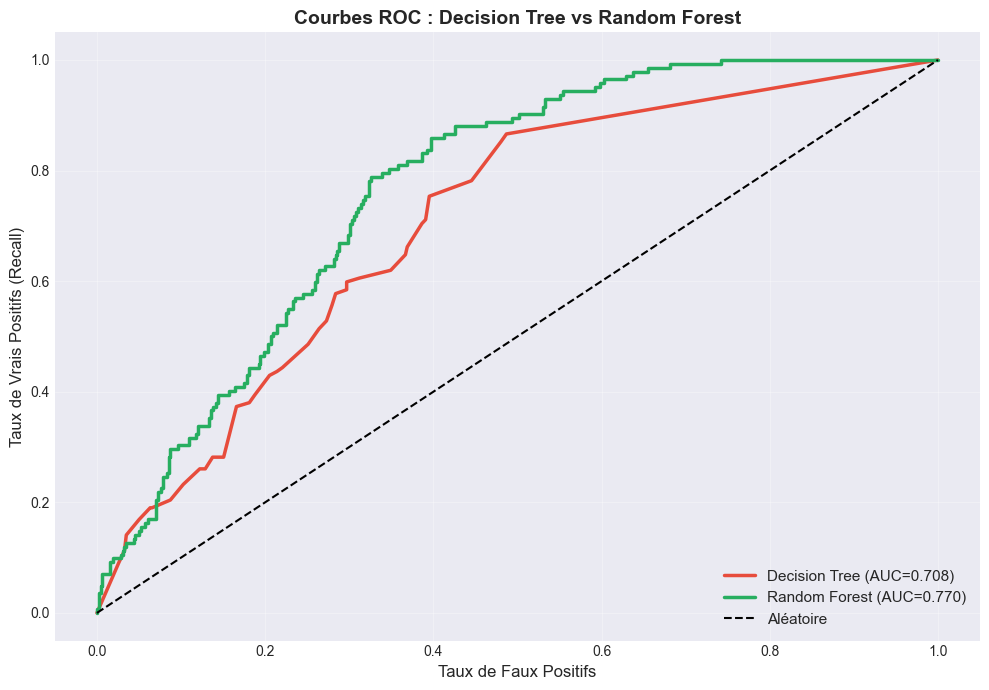

Observation : La Random Forest domine la Decision Tree sur presque toute la courbe


In [35]:
# SOLUTION TEACHER
# Calcul des courbes ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Visualisation
plt.figure(figsize=(10, 7))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={roc_auc_score(y_test, y_pred_proba_dt):.3f})',
         linewidth=2.5, color='#e74c3c')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})',
         linewidth=2.5, color='#27ae60')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire', linewidth=1.5)

plt.xlabel('Taux de Faux Positifs', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Recall)', fontsize=12)
plt.title('Courbes ROC : Decision Tree vs Random Forest', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observation : La Random Forest domine la Decision Tree sur presque toute la courbe")

#### TODO 1.5 : Visualisation - Matrices de confusion

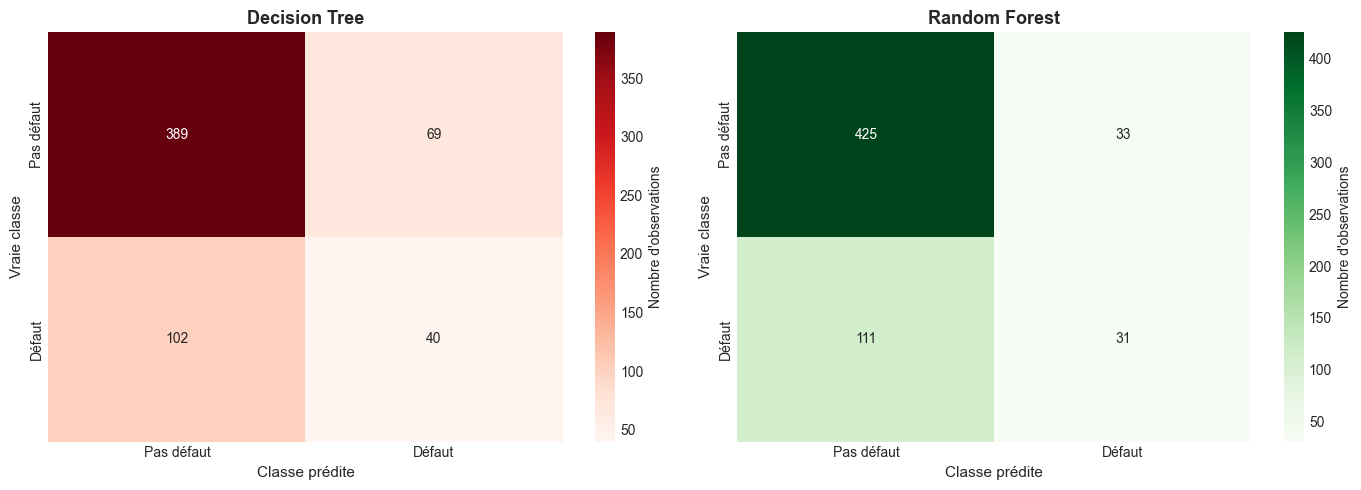

Analyse des erreurs :

Decision Tree :
  Faux Négatifs (défauts manqués) : 102
  Faux Positifs (refus injustifiés): 69

Random Forest :
  Faux Négatifs (défauts manqués) : 111
  Faux Positifs (refus injustifiés): 33

→ Réduction FN : -9 (économie de -450,000€ si 50k€/défaut)


In [36]:
# SOLUTION TEACHER
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['Pas défaut', 'Défaut'],
            yticklabels=['Pas défaut', 'Défaut'],
            cbar_kws={'label': 'Nombre d\'observations'})
axes[0].set_title('Decision Tree', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Vraie classe', fontsize=11)
axes[0].set_xlabel('Classe prédite', fontsize=11)

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Pas défaut', 'Défaut'],
            yticklabels=['Pas défaut', 'Défaut'],
            cbar_kws={'label': 'Nombre d\'observations'})
axes[1].set_title('Random Forest', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Vraie classe', fontsize=11)
axes[1].set_xlabel('Classe prédite', fontsize=11)

plt.tight_layout()
plt.show()

print("Analyse des erreurs :")
print(f"\nDecision Tree :")
print(f"  Faux Négatifs (défauts manqués) : {cm_dt[1,0]}")
print(f"  Faux Positifs (refus injustifiés): {cm_dt[0,1]}")
print(f"\nRandom Forest :")
print(f"  Faux Négatifs (défauts manqués) : {cm_rf[1,0]}")
print(f"  Faux Positifs (refus injustifiés): {cm_rf[0,1]}")
print(f"\n→ Réduction FN : {cm_dt[1,0] - cm_rf[1,0]} (économie de {(cm_dt[1,0] - cm_rf[1,0]) * 50000:,.0f}€ si 50k€/défaut)")

** Questions de réflexion :**
1. Pourquoi la Random Forest performe mieux que l'arbre seul ?
2. Quel impact financier a la réduction des faux négatifs ?
3. Les deux modèles ont les mêmes hyperparamètres (max_depth=10, etc.). Pourquoi la RF ne surfit pas ?

---
### Exercice 2 : Tuning des Hyperparamètres (20 min)

**Objectif :** Optimiser une Random Forest avec GridSearchCV

#### TODO 2.1 : GridSearch sur les hyperparamètres clés

In [37]:
# SOLUTION TEACHER
# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

print(f"GridSearch sur Random Forest")
print(f"Nombre de combinaisons : {np.prod([len(v) for v in param_grid.values()])}")
print(f"Avec CV=5 : {np.prod([len(v) for v in param_grid.values()]) * 5} modèles à entraîner")
print(f"\nCe calcul peut prendre 2-3 minutes...\n")

# GridSearch
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n" + "="*70)
print("RÉSULTATS DU GRIDSEARCH")
print("="*70)
print(f"\nMeilleurs hyperparamètres :")
for param, value in grid_search.best_params_.items():
    print(f"  {param:20s} : {value}")

print(f"\nMeilleur score F1 (CV) : {grid_search.best_score_:.4f}")

GridSearch sur Random Forest
Nombre de combinaisons : 216
Avec CV=5 : 1080 modèles à entraîner

Ce calcul peut prendre 2-3 minutes...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

RÉSULTATS DU GRIDSEARCH

Meilleurs hyperparamètres :
  max_depth            : 15
  max_features         : sqrt
  min_samples_leaf     : 5
  min_samples_split    : 20
  n_estimators         : 100

Meilleur score F1 (CV) : 0.4130


#### TODO 2.2 : Évaluation du modèle optimal

In [38]:
# SOLUTION TEACHER
# Modèle optimal
rf_optimal = grid_search.best_estimator_

# Prédictions
y_pred_optimal = rf_optimal.predict(X_test)
y_pred_proba_optimal = rf_optimal.predict_proba(X_test)[:, 1]

print("="*70)
print("PERFORMANCES DU MODÈLE OPTIMAL")
print("="*70)
print(f"Accuracy  : {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision : {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred_optimal):.4f}")
print(f"F2-Score  : {fbeta_score(y_test, y_pred_optimal, beta=2):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_pred_proba_optimal):.4f}")

# Comparaison avec le modèle de base
print("\nAmélioration vs RF de base :")
improvement = (f1_score(y_test, y_pred_optimal) - f1_score(y_test, y_pred_rf)) * 100
print(f"  F1-Score : {improvement:+.2f} points")

PERFORMANCES DU MODÈLE OPTIMAL
Accuracy  : 0.7583
Precision : 0.4769
Recall    : 0.2183
F1-Score  : 0.2995
F2-Score  : 0.2449
ROC-AUC   : 0.7755

Amélioration vs RF de base :
  F1-Score : -0.15 points


#### TODO 2.3 : Impact du nombre d'arbres

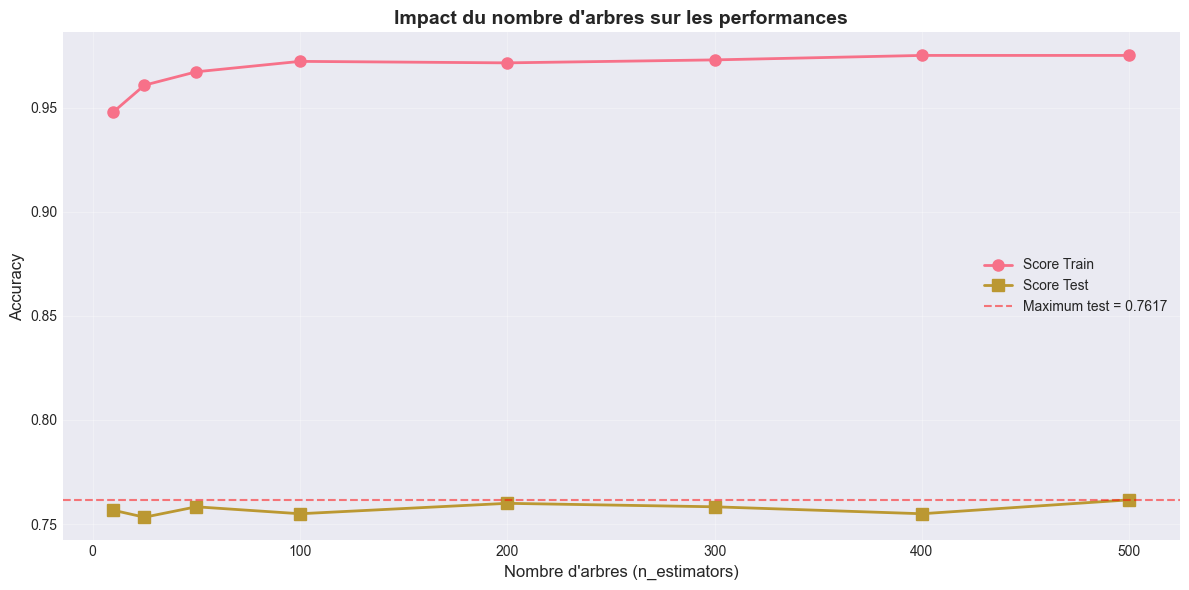

Observations :
  - Score test se stabilise autour de 500 arbres
  - Pas d'overfitting même avec 500 arbres (écart train-test stable)
  - Trade-off temps/performance : 100-200 arbres souvent optimal


In [39]:
# SOLUTION TEACHER
# Test de différents nombres d'arbres
n_estimators_range = [10, 25, 50, 100, 200, 300, 400, 500]
train_scores = []
test_scores = []

for n in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    train_scores.append(rf_temp.score(X_train, y_train))
    test_scores.append(rf_temp.score(X_test, y_test))

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, train_scores, 'o-', label='Score Train', linewidth=2, markersize=8)
plt.plot(n_estimators_range, test_scores, 's-', label='Score Test', linewidth=2, markersize=8)
plt.xlabel('Nombre d\'arbres (n_estimators)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Impact du nombre d\'arbres sur les performances', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=max(test_scores), color='red', linestyle='--', alpha=0.5,
           label=f'Maximum test = {max(test_scores):.4f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Observations :")
print(f"  - Score test se stabilise autour de {n_estimators_range[np.argmax(test_scores)]} arbres")
print(f"  - Pas d'overfitting même avec 500 arbres (écart train-test stable)")
print(f"  - Trade-off temps/performance : 100-200 arbres souvent optimal")

---
### Exercice 3 : Feature Importance et Interprétation (15 min)

**Objectif :** Analyser quelles variables sont les plus importantes

#### TODO 3.1 : Calcul et visualisation des importances

IMPORTANCE DES VARIABLES
             Variable  Importance
    ratio_endettement    0.403931
      revenus_annuels    0.193938
                  age    0.120798
      montant_epargne    0.109440
    anciennete_emploi    0.100837
       nombre_credits    0.039756
nb_incidents_paiement    0.031300

Top 3 variables : ratio_endettement, revenus_annuels, age
Contribution cumulée top 3 : 71.87%


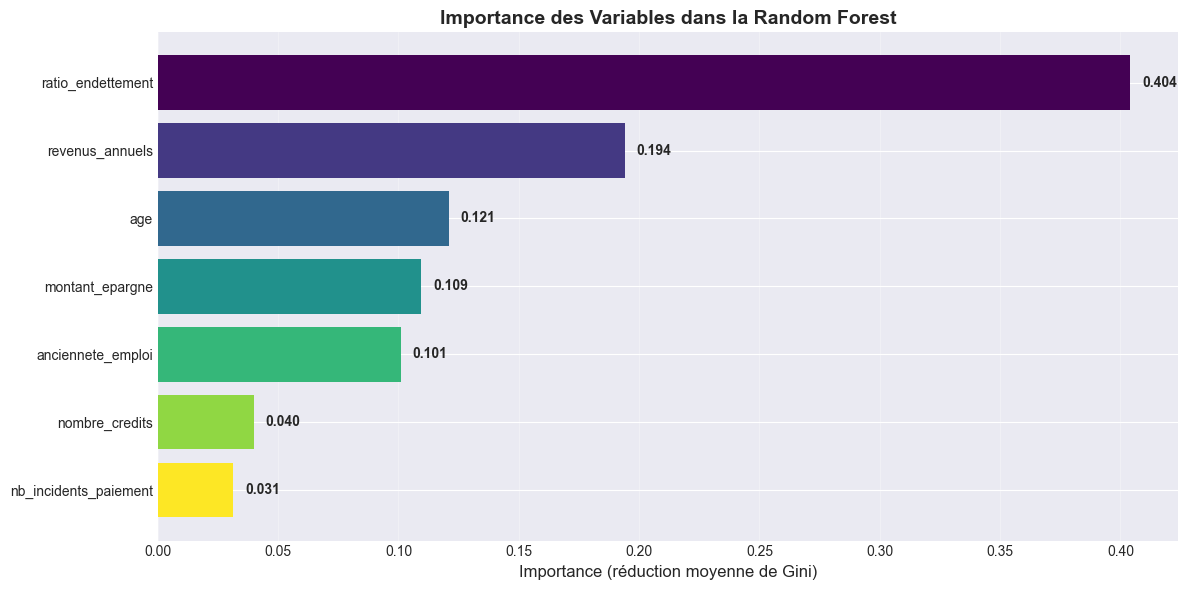

In [40]:
# SOLUTION TEACHER
# Feature importance du modèle optimal
importances = rf_optimal.feature_importances_
feature_names = X.columns

# DataFrame pour tri
importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("="*60)
print("IMPORTANCE DES VARIABLES")
print("="*60)
print(importance_df.to_string(index=False))
print(f"\nTop 3 variables : {', '.join(importance_df['Variable'].head(3).values)}")
print(f"Contribution cumulée top 3 : {importance_df['Importance'].head(3).sum():.2%}")

# Visualisation
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
bars = plt.barh(importance_df['Variable'], importance_df['Importance'], color=colors)

# Ajouter les valeurs
for i, (bar, imp) in enumerate(zip(bars, importance_df['Importance'])):
    plt.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=10, fontweight='bold')

plt.xlabel('Importance (réduction moyenne de Gini)', fontsize=12)
plt.title('Importance des Variables dans la Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#### TODO 3.2 : Comparaison DT vs RF - Feature Importance

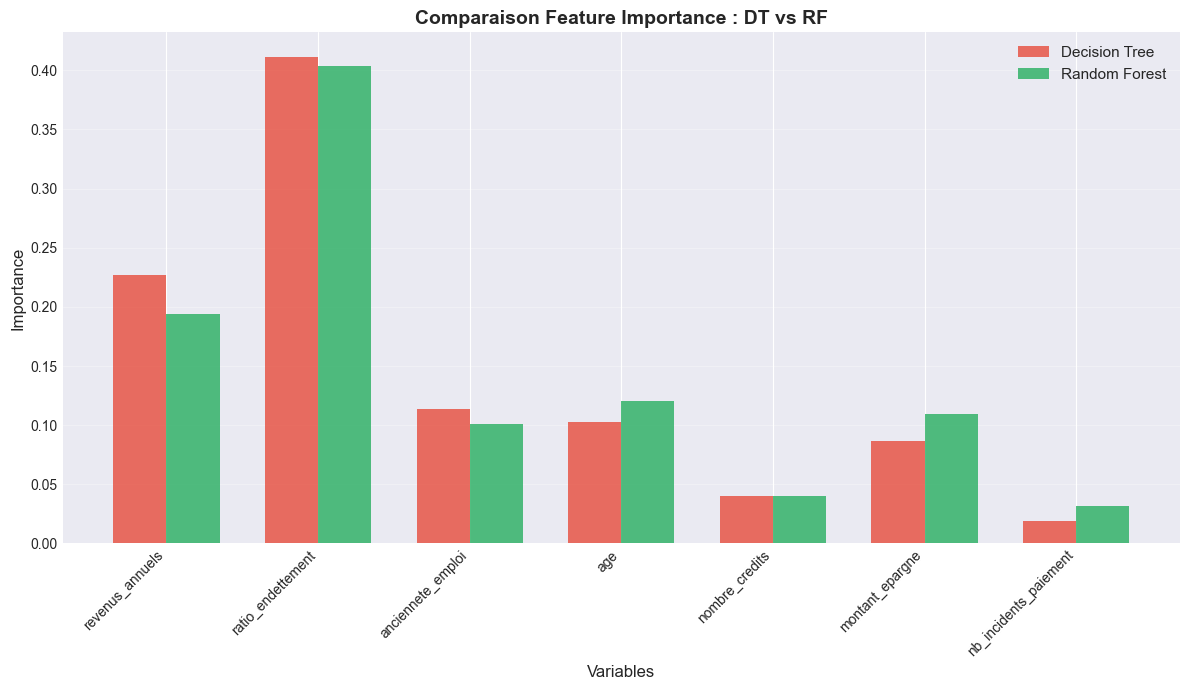

Observations :
  - DT : importance concentrée sur 2-3 variables (arbre unique)
  - RF : importance plus distribuée (moyenne de 100 arbres)
  - RF donne une vision plus robuste des variables importantes


In [41]:
# SOLUTION TEACHER
# Comparaison des importances
comparison_importance = pd.DataFrame({
    'Variable': feature_names,
    'DT_Importance': dt.feature_importances_,
    'RF_Importance': rf_optimal.feature_importances_
})

# Visualisation comparative
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(feature_names))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_importance['DT_Importance'], 
               width, label='Decision Tree', alpha=0.8, color='#e74c3c')
bars2 = ax.bar(x + width/2, comparison_importance['RF_Importance'], 
               width, label='Random Forest', alpha=0.8, color='#27ae60')

ax.set_xlabel('Variables', fontsize=12)
ax.set_ylabel('Importance', fontsize=12)
ax.set_title('Comparaison Feature Importance : DT vs RF', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations :")
print("  - DT : importance concentrée sur 2-3 variables (arbre unique)")
print("  - RF : importance plus distribuée (moyenne de 100 arbres)")
print("  - RF donne une vision plus robuste des variables importantes")

#### TODO 3.3 : Visualisation d'arbres individuels

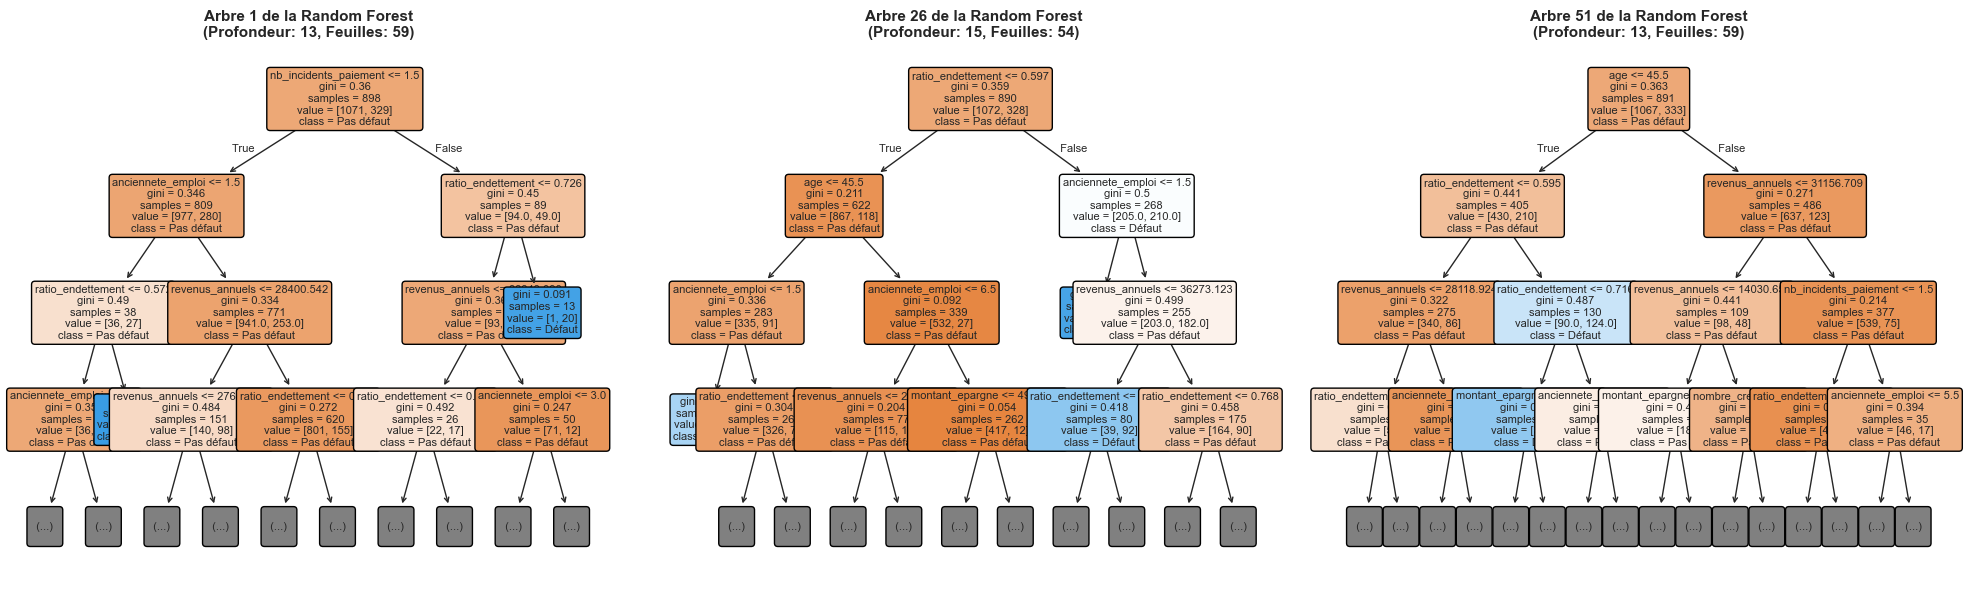

Observations :
  - Chaque arbre est différent (bootstrap + randomisation)
  - Variables de division différentes entre arbres
  - C'est cette diversité qui fait la force de la Random Forest !


In [42]:
# SOLUTION TEACHER
from sklearn.tree import plot_tree

# Visualiser 3 arbres aléatoires de la forêt
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

tree_indices = [0, 25, 50]  # Premier, milieu, et un autre arbre

for idx, (ax, tree_idx) in enumerate(zip(axes, tree_indices)):
    tree = rf_optimal.estimators_[tree_idx]
    
    plot_tree(tree,
             feature_names=feature_names,
             class_names=['Pas défaut', 'Défaut'],
             filled=True,
             rounded=True,
             fontsize=8,
             max_depth=3,  # Limiter l'affichage
             ax=ax)
    
    ax.set_title(f'Arbre {tree_idx+1} de la Random Forest\n'
                f'(Profondeur: {tree.get_depth()}, Feuilles: {tree.get_n_leaves()})',
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Observations :")
print("  - Chaque arbre est différent (bootstrap + randomisation)")
print("  - Variables de division différentes entre arbres")
print("  - C'est cette diversité qui fait la force de la Random Forest !")

---
### Exercice 4 : Out-of-Bag Score et Stabilité (10 min)

**Objectif :** Utiliser le OOB score et analyser la stabilité des prédictions

#### TODO 4.1 : Calcul du OOB Score

In [43]:
# SOLUTION TEACHER
# Entraîner RF avec OOB score activé
rf_oob = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_oob.fit(X_train, y_train)

# Comparaison des scores
print("="*60)
print("VALIDATION PAR OUT-OF-BAG")
print("="*60)
print(f"OOB Score (train)     : {rf_oob.oob_score_:.4f}")
print(f"Score sur test set    : {rf_oob.score(X_test, y_test):.4f}")
print(f"Différence            : {abs(rf_oob.oob_score_ - rf_oob.score(X_test, y_test)):.4f}")

print("\n Le OOB score est une estimation non biaisée de la performance")
print("   → Pas besoin de validation croisée supplémentaire !")
print("   → Économie de temps de calcul")

VALIDATION PAR OUT-OF-BAG
OOB Score (train)     : 0.8007
Score sur test set    : 0.7600
Différence            : 0.0407

 Le OOB score est une estimation non biaisée de la performance
   → Pas besoin de validation croisée supplémentaire !
   → Économie de temps de calcul


#### TODO 4.2 : Learning Curves

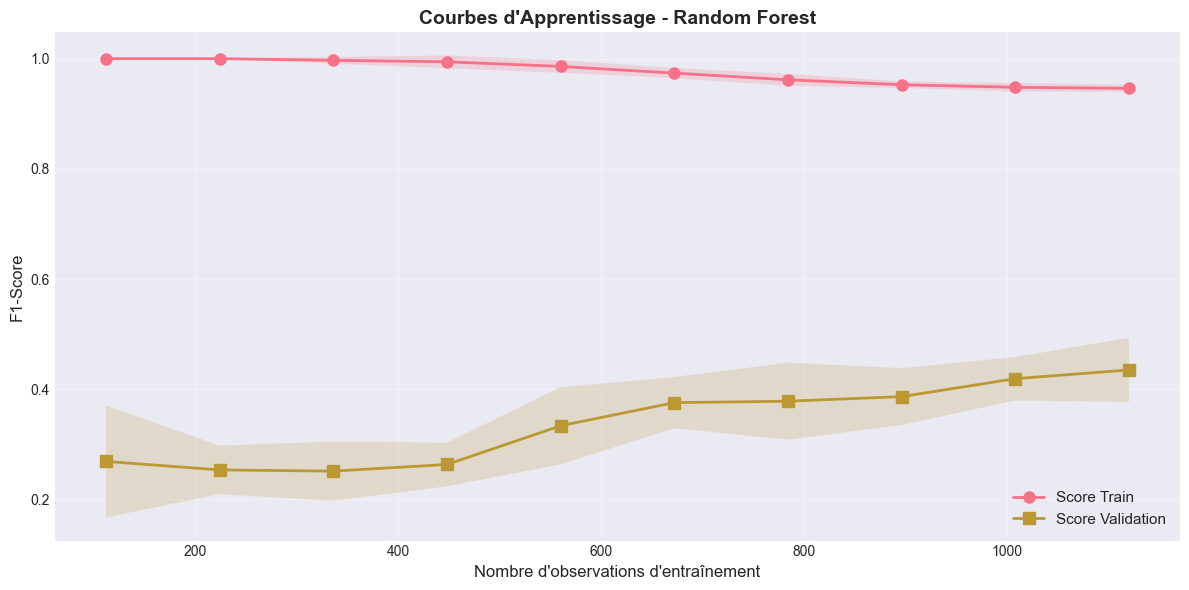

Analyse des courbes :
  - Gap train-validation final : 0.5111
  - Score se stabilise avec ~896 observations
  - Variance faible (bandes étroites) = modèle stable


In [44]:
# SOLUTION TEACHER
# Calcul des learning curves
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Score Train', linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, 's-', label='Score Validation', linewidth=2, markersize=8)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel('Nombre d\'observations d\'entraînement', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Courbes d\'Apprentissage - Random Forest', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Analyse des courbes :")
print(f"  - Gap train-validation final : {(train_mean[-1] - val_mean[-1]):.4f}")
print(f"  - Score se stabilise avec ~{int(train_sizes[-3])} observations")
print(f"  - Variance faible (bandes étroites) = modèle stable")

---
## Partie 3 : Projet Non Guidé (1h30)

### Mission : Système de Scoring Crédit Optimal

**Dataset :** Lending Club Loan Data (données réelles de prêts P2P)

**Contexte métier :**  
Vous travaillez pour une fintech qui souhaite automatiser ses décisions de crédit. 
Vous devez construire le meilleur modèle possible pour prédire le défaut de paiement.

**Contraintes :**
- Privilégier le **Recall** (détecter les défauts)
- Maintenir une **Precision raisonnable** (éviter trop de refus)
- Le modèle doit être **explicable** (feature importance)
- Comparer au minimum : Decision Tree, Random Forest, et un modèle Baseline

**Livrables attendus :**
1. Analyse exploratoire (distributions, corrélations, déséquilibre)
2. Feature engineering (création de variables pertinentes)
3. Comparaison de 3+ modèles avec métriques complètes
4. Visualisations (ROC curves, feature importance, matrices confusion)
5. Modèle final optimisé (GridSearch)
6. Interprétation métier et recommandations
7. (Bonus) Test de modèles ensemblistes avancés (XGBoost, Stacking)

---

### Chargement du Dataset Lending Club

In [45]:
# Chargement des données Lending Club
# Dataset simplifié pour le TD (version préparée)

# Si le dataset n'est pas disponible, on génère des données synthétiques réalistes
np.random.seed(42)
n_samples = 10000

lending_data = pd.DataFrame({
    'loan_amnt': np.random.lognormal(9.5, 0.7, n_samples),  # Montant du prêt
    'funded_amnt': np.random.lognormal(9.5, 0.7, n_samples),  # Montant financé
    'int_rate': np.random.uniform(5, 25, n_samples),  # Taux d'intérêt
    'installment': np.random.lognormal(5.5, 0.6, n_samples),  # Mensualité
    'annual_inc': np.random.lognormal(11, 0.8, n_samples),  # Revenu annuel
    'dti': np.random.uniform(0, 40, n_samples),  # Debt-to-income ratio
    'fico_range': np.random.normal(700, 50, n_samples),  # Score FICO
    'revol_bal': np.random.lognormal(8.5, 1.2, n_samples),  # Solde revolving
    'revol_util': np.random.uniform(0, 100, n_samples),  # Utilisation revolving
    'total_acc': np.random.poisson(20, n_samples),  # Nombre total de comptes
    'open_acc': np.random.poisson(10, n_samples),  # Comptes ouverts
    'pub_rec': np.random.poisson(0.2, n_samples),  # Dossiers publics
    'delinq_2yrs': np.random.poisson(0.3, n_samples),  # Impayés 2 ans
    'inq_last_6mths': np.random.poisson(1, n_samples),  # Enquêtes 6 mois
    'emp_length': np.random.randint(0, 40, n_samples),  # Ancienneté emploi
    'home_ownership': np.random.choice(['RENT', 'MORTGAGE', 'OWN'], n_samples, 
                                       p=[0.4, 0.45, 0.15]),
    'purpose': np.random.choice(['debt_consolidation', 'credit_card', 'home_improvement',
                                'major_purchase', 'small_business'], n_samples,
                               p=[0.5, 0.2, 0.15, 0.1, 0.05]),
    'term': np.random.choice([36, 60], n_samples, p=[0.7, 0.3])
})

# Variable cible : défaut de paiement
default_prob = (
    0.05 +
    0.30 * (lending_data['int_rate'] > 15) +
    0.25 * (lending_data['dti'] > 25) +
    0.20 * (lending_data['fico_range'] < 650) +
    0.15 * (lending_data['revol_util'] > 70) +
    0.15 * (lending_data['delinq_2yrs'] > 0) +
    0.10 * (lending_data['pub_rec'] > 0) -
    0.10 * (lending_data['annual_inc'] > 75000)
)
default_prob = np.clip(default_prob, 0, 1)
lending_data['loan_status'] = (np.random.random(n_samples) < default_prob).astype(int)

print("DATASET LENDING CLUB CHARGÉ")
print("="*70)
print(f"Nombre d'observations : {len(lending_data):,}")
print(f"Nombre de variables   : {len(lending_data.columns)-1}")
print(f"Taux de défaut        : {lending_data['loan_status'].mean():.2%}")
print(f"\nVariables disponibles :")
print(lending_data.columns.tolist())
print(f"\nPremières lignes :")
print(lending_data.head())
print(f"\nStatistiques descriptives :")
print(lending_data.describe())

DATASET LENDING CLUB CHARGÉ
Nombre d'observations : 10,000
Nombre de variables   : 18
Taux de défaut        : 39.07%

Variables disponibles :
['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range', 'revol_bal', 'revol_util', 'total_acc', 'open_acc', 'pub_rec', 'delinq_2yrs', 'inq_last_6mths', 'emp_length', 'home_ownership', 'purpose', 'term', 'loan_status']

Premières lignes :
      loan_amnt   funded_amnt   int_rate  installment     annual_inc  \
0  18914.798935   8308.660543   6.113328    47.235691  102209.798413   
1  12127.307284  10787.575949  24.715352   889.460077  115045.799776   
2  21023.202268   8794.073057  21.000370   205.946555   32959.940913   
3  38797.880564  14433.290142  22.376181   218.384956   24790.490630   
4  11340.012025  30884.971088  18.885886   236.037398   37434.889688   

         dti  fico_range     revol_bal  revol_util  total_acc  open_acc  \
0   0.502482  699.624259   1414.696898   90.118068         25        13   
1 

### INDICATIONS ET PISTES

Voici des suggestions pour structurer votre travail (non obligatoires, vous êtes libres !) :

#### 1. Analyse Exploratoire (20 min)
- Distribution de la variable cible (déséquilibre ?)
- Distributions des variables numériques (histogrammes, boxplots)
- Variables catégorielles (home_ownership, purpose, term)
- Corrélations entre variables
- Valeurs manquantes ?

#### 2. Feature Engineering (15 min)
**Variables potentielles à créer :**
- Ratio `loan_amnt / annual_inc` (charge du prêt)
- Ratio `revol_bal / annual_inc`
- Interaction `int_rate × dti`
- Encodage des variables catégorielles (one-hot ou label encoding)

#### 3. Modèle Baseline (10 min)
- Logistic Regression simple
- Ou : prédire toujours la classe majoritaire
- Établir les performances de référence

#### 4. Decision Tree (10 min)
- Entraîner avec hyperparamètres raisonnables
- Évaluer et visualiser

#### 5. Random Forest (15 min)
- Version de base
- GridSearch pour optimisation
- Feature importance

#### 6. Comparaison et Visualisations (15 min)
- Tableau comparatif des métriques
- ROC curves sur même graphique
- Matrices de confusion
- Feature importance RF

#### 7. Synthèse et Recommandations (10 min)
- Quel modèle recommandez-vous et pourquoi ?
- Analyse coût/bénéfice
- Limites et améliorations possibles
- Considérations pour la mise en production

---

### À VOUS DE JOUER !

Créez autant de cellules que nécessaire ci-dessous.

In [46]:
# CELLULE PROJET 1 : Analyse exploratoire



In [47]:
# CELLULE PROJET 2 : Feature engineering



In [48]:
# CELLULE PROJET 3 : Modèle baseline



In [49]:
# CELLULE PROJET 4 : Decision Tree



In [50]:
# CELLULE PROJET 5 : Random Forest



In [51]:
# CELLULE PROJET 6 : GridSearch RF



In [52]:
# CELLULE PROJET 7 : Comparaison et visualisations



---
## Synthèse Finale du Projet

### TODO : Rédigez votre rapport

Répondez aux questions suivantes :

**1. Meilleur modèle :**

[Votre réponse]

**2. Performances comparatives :**

[Tableau récapitulatif]

**3. Top 5 variables importantes :**

[Votre réponse]

**4. Analyse coût/bénéfice :**

[Impact financier des FN et FP]

**5. Recommandations pour la production :**

[Votre réponse]

**6. Limites et améliorations :**

[Votre réponse]

---
## Ressources Complémentaires

### Documentation
- [Random Forests - scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html#forest)
- [RandomForestClassifier API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### Articles de référence
- Breiman, L. (2001). "Random Forests". Machine Learning, 45(1), 5-32.
- Breiman, L. (1996). "Bagging Predictors". Machine Learning, 24(2), 123-140.

---

## Fin du TD Random Forests

Vous maîtrisez maintenant :
- Les concepts d'ensemble (Bagging)
- Les Random Forests et leur tuning
- L'interprétation des modèles (feature importance)
- La comparaison rigoureuse de modèles